## Atom counting
The idea is segmenting the image (optional), running SIFT to detect the average size of the atoms/features and extract the median one.
After calculating a correlation map between that and the original image, count the peaks and apply some filters.

In [5]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
import utilities
import os
import configparser
from sklearn.cluster import AgglomerativeClustering
from skimage.feature import match_template
from skimage.feature import peak_local_max

In [ ]:
# Input Image:
path = "./examples/atom counting/small_SrTiO3_1244/"
filename = "small_SrTiO3_1244"
extension = ".png"
img = cv.imread(path+filename+extension, 0)

#### Rescale the image if needed.
If features have a few pixels' radius, rescaling can make the predictions more accurate. <br>
Turn off if not needed, it slows down the calculations!

In [7]:
# scale_factor = 2
# img = cv.resize(img, None, fx=scale_factor, fy=scale_factor, interpolation=cv.INTER_CUBIC)

Initial image:


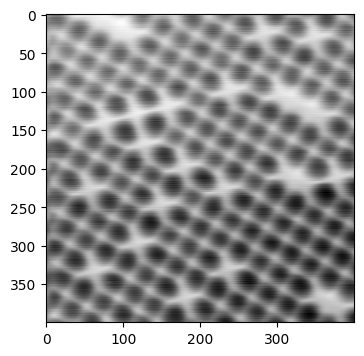

In [8]:
img_original = np.copy(img)
print('Initial image:')
plt.figure(figsize=(4,4))
plt.imshow(img, cmap="gray")
plt.show()

Segment the image with Otsu's method. Use it in case you want to analyze the segmented image instead of the full one.

Image shape: (400, 400)
Found threshold: 133.0
Group 0 (white): 50.14 %
Group 1 (black): 49.86 %


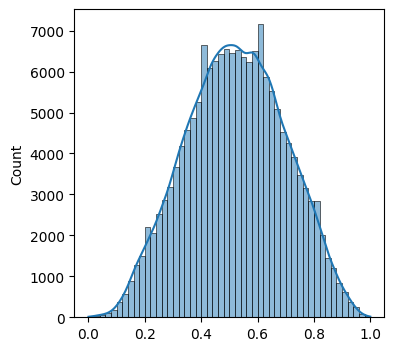

Binarized image:


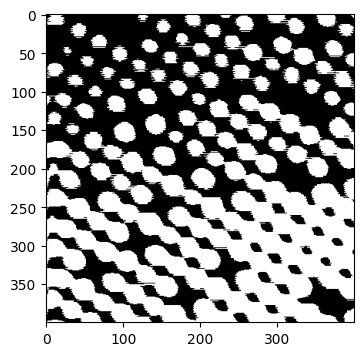

In [33]:
thresh, binary_img, segm_img0, segm_img1 = utilities.segmentation(img, erosion=False)

M, N = img.shape
flattened_image = img_original.flatten()
plt.figure(figsize=(4, 4))
sns.histplot(flattened_image, kde=True, bins=50)
plt.show()

binary_img_tmp = (binary_img/255).flatten().tolist()
count0 = binary_img_tmp.count(0)
count1 = binary_img_tmp.count(1)
perc0 = round(count0/len(flattened_image)*100, 2)
perc1 = round(count1/len(flattened_image)*100, 2)

print("Binarized image:")
plt.figure(figsize=(4, 4))
plt.imshow(binary_img, cmap="binary")
plt.show()

original, segm_img0, segm_img1


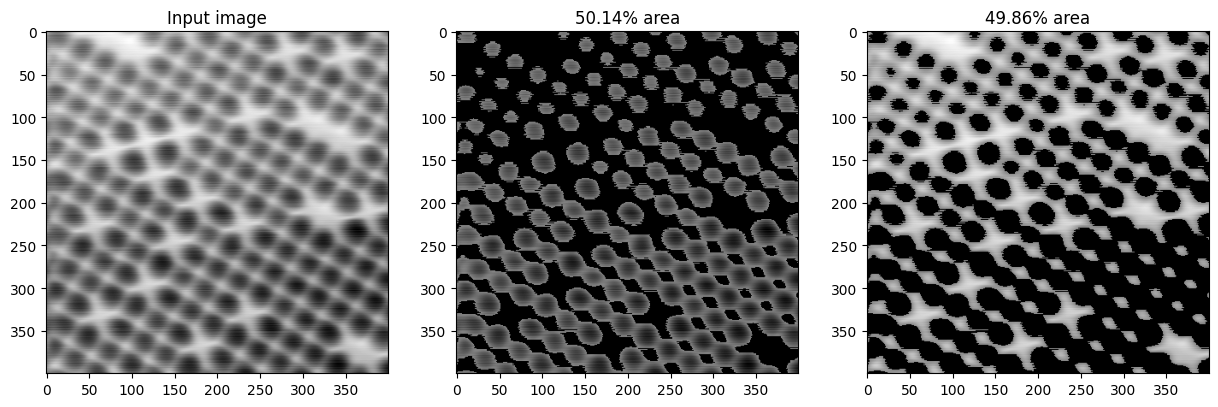

In [10]:
figure, axis = plt.subplots(1, 3, figsize=(15, 25))
axis[0].title.set_text('Input image')
axis[0].imshow(img_original, cmap="gray")
axis[1].title.set_text(str(perc0)+'% area')
axis[1].imshow(segm_img0, cmap="gray", vmin=0, vmax=255)
axis[2].title.set_text(str(perc1)+'% area')
axis[2].imshow(segm_img1, cmap="gray", vmin=0, vmax=255)
print('original, segm_img0, segm_img1')
plt.show()

plt.imsave(path+'last_segm_img0.png', segm_img0, cmap="gray", vmin=0, vmax=255)
plt.imsave(path+'last_segm_img1.png', segm_img1, cmap="gray", vmin=0, vmax=255)

#### Analyzing full or segmented image:
Uncomment the next cell to analyze segm_img0 or 1 (select it in *filename* variable). Leave commented to analyze the initial image.

In [11]:

# filename = 'last_segm_img0' ; extension = '.png'
# inputfile = path + filename + extension
# img = cv.imread(inputfile)

# if len(img[0][0])>1: #i.e. not grayscale
#     img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

## Calculating the median crop
Extract the median appearence of the feature of interest. Successful predictions depend on parameters' setup. <br>
The initial part of this section comes mostly from AiSurf's main code. <br>
**Tip:** keep in mind that the feature detection, clustering and filtering is used to extract the median crop, so there's no need to detect a large amount of relevant features. If unsure about the parameter tuning, start with a relatively high *cThr* and decrease it when you see that the atomic/relevant features are being detected. The reference cluster (see below) should contain mostly the feature one would like to count, independently from how many of those features are included in the cluster.

In [12]:
if os.path.isfile(path+"parameters.ini"):
    conf = configparser.ConfigParser(allow_no_value=True)
    conf.read_file(open(path+"parameters.ini"))
    
    #[SIFT]
    cThr = conf.getfloat('SIFT', 'cThr', fallback=0.003)
    sigma = conf.getfloat('SIFT', 'sigma', fallback=4)
    nOctLayers = conf.getint('SIFT', 'nOctLayers', fallback=8)
    
    #[Keypoint filtering]
    size_Threshold = conf.getfloat('Keypoint filtering', 'size_Threshold', fallback=2)
    edge_Threshold = conf.getfloat('Keypoint filtering', 'edge_Threshold', fallback=1)
    
    #[Keypoint Clustering]
    clustering_span_kp = range(conf.getint('Keypoint Clustering', 'cluster_kp_low',
                                           fallback=2),
                               conf.getint('Keypoint Clustering', 'cluster_kp_high',
                                           fallback=12))
    cluster_choice = conf.getint('Keypoint Clustering', 'cluster_choice', fallback=1)
    
    #[Nearest Neighbours]
    cluster_kNN_low = conf.getint('Nearest Neighbours', 'cluster_kNN_low', fallback=6)
    cluster_kNN_high = conf.getint('Nearest Neighbours', 'cluster_kNN_high', fallback=24)
    cluster_span_kNN = range(cluster_kNN_low, cluster_kNN_high)
    clustersize_Threshold = conf.getfloat('Nearest Neighbours', 'clustersize_Threshold',
                                          fallback=0.3)
    
    #[Sublattice Lookup]
    clustering_span_SUBL = range(conf.getint('Sublattice lookup', 'cluster_SUBL_low',
                                         fallback=2),
                          conf.getint('Sublattice lookup', 'cluster_SUBL_high',
                                      fallback=4))
    
    #[Deviation plot]
    k2 = conf.getint('Deviation plot', 'k2', fallback=10)
    rtol_rel = conf.getfloat('Deviation plot', 'rtol_rel', fallback=4)
    arrow_width = conf.getfloat('Deviation plot', 'arrow_width', fallback=0.003)
    c_max_arrow = conf.getfloat('Deviation plot', 'c_max_arrow', fallback=None)
    
    #[Symmetry check]
    sym_yesno = conf.getfloat('Symmetry check', 'sym_yesno', fallback=1.1)

    #[Atom count]
    r_rescale = conf.getfloat('Atom count', 'r_rescale', fallback=1)
    min_correl = conf.getfloat('Atom count', 'min_correl', fallback=0.4)
    d_rescale = conf.getfloat('Atom count', 'd_rescale', fallback=0.8)

    
else:       # DO NOT MODIFY! Default values here, modify the parameters.ini file if needed.
    #[SIFT]
    cThr = 0.003
    sigma = 4
    nOctLayers = 8
    
    #[Keypoint filtering]
    size_Threshold = 2
    edge_Threshold = 1

    #[Keypoint Clustering]
    clustering_span_kp = range(2, 12)
    cluster_choice = 1
    
    #[Nearest Neighbours]
    cluster_kNN_low = 6
    cluster_kNN_high = 24
    cluster_span_kNN = range(cluster_kNN_low, cluster_kNN_high)
    clustersize_Threshold = 0.3

    #[Sublattice lookup]
    clustering_span_SUBL = range(2, 4)

    #[Deviation plot]
    k2 = 10
    rtol_rel = 4
    arrow_width = 0.003
    c_max_arrow = None
    
    #[Symmetry check]
    sym_yesno = 1.1

    #[Atom count]
    r_rescale = 1
    min_correl = 0.4
    d_rescale = 0.8


print("These values will be used for the analysis:")
print('cThr:', cThr)
print('sigma:', sigma)
print('nOctLayers:', nOctLayers) 
print('size_Threshold:', size_Threshold)
print('edge_Threshold:', edge_Threshold )
print('clustering_span_kp:', clustering_span_kp)
print('cluster_choice:', cluster_choice)
print('cluster_kNN_low:', cluster_kNN_low)
print('cluster_kNN_high:', cluster_kNN_high)
print('clustersize_Threshold:', clustersize_Threshold)
print('clustering_span_SUBL:', clustering_span_SUBL)
print('k2:', k2)
print('rtol_rel:', rtol_rel)
print('arrow_width:', arrow_width)
print('c_max_arrow:', c_max_arrow)
print('sym_yesno:', sym_yesno)
print('r_rescale:', r_rescale)
print('min_correl:', min_correl)
print('d_rescale:', d_rescale)

These values will be used for the analysis:
cThr: 0.003
sigma: 4.0
nOctLayers: 8
size_Threshold: 2.0
edge_Threshold: 1.5
clustering_span_kp: range(2, 12)
cluster_choice: 2
cluster_kNN_low: 6
cluster_kNN_high: 24
clustersize_Threshold: 0.3
clustering_span_SUBL: range(2, 6)
k2: 10
rtol_rel: 4.0
arrow_width: 0.003
c_max_arrow: None
sym_yesno: 1.1
r_rescale: 1
min_correl: 0.4
d_rescale: 0.8


Image to be inspected:


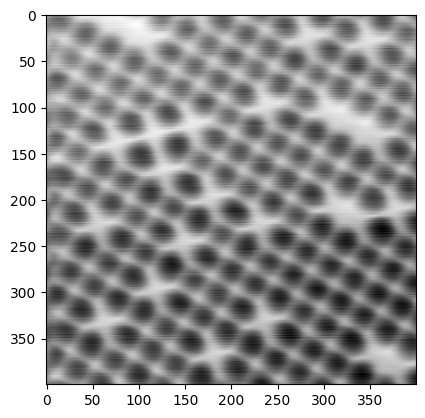

In [13]:
gray = np.copy(img)
gray_original = gray

print("Image to be inspected:")
plt.figure(dpi=100, facecolor="w", edgecolor="k")
gray_cmap = utilities.get_correctGreyCmap("greyscale")
plt.imshow(gray, cmap=gray_cmap, vmin=0, vmax=255)
plt.show()

Threshold: 0.003 
Sigma: 4.0 
Number of octave layers: 8


[ WARN:0@434.971] global shadow_sift.hpp:13 SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


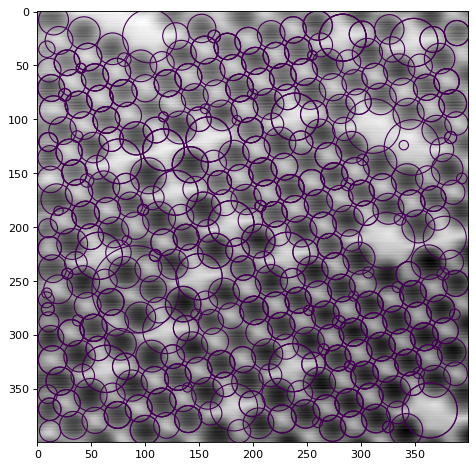

In [14]:
#SIFT application:
print('Threshold:', cThr, '\nSigma:', sigma, '\nNumber of octave layers:', nOctLayers)

sift = cv.xfeatures2d.SIFT_create(contrastThreshold=cThr, sigma=sigma, nOctaveLayers=nOctLayers)
kp = sift.detect(gray, None)
utilities.plot_clusters(np.array(gray_original), kp, labels=np.zeros(np.size(kp)), fill=False, colormap="viridis")

##### Some keypoints filtering...

In [15]:
sizes = [kp[i].size for i in range(np.size(kp))]
size_med = np.median(sizes)
kp = list(kp) 
wrongsize_index = [i for i in range(np.size(kp)) if kp[i].size>size_Threshold*size_med or kp[i].size<size_med/size_Threshold]
wrongsize_index.reverse()
for i in wrongsize_index:
    del kp[i]

In [16]:
border = edge_Threshold*size_med
edgeKP_indices = []
for i in range(np.size(kp)):
    if (kp[i].pt[0]<border or kp[i].pt[0]>np.shape(gray)[1]-border or\
        kp[i].pt[1]<border or kp[i].pt[1]>np.shape(gray)[0]-border):
        edgeKP_indices.append(i)
edgeKP_indices.reverse()
for i in edgeKP_indices:
    del kp[i]

In [17]:
kp, des_with_rot_inv = sift.compute(gray, kp) #~Atomtype Identification better result when
                                              #doing descriptors before removing same-x kp.
kp = list(kp)
x = np.array([kp[i].pt for i in range(np.size(kp))])
x, uniqueXindices = np.unique(x, return_index=True, axis=0)

for i in range(np.size(kp)-1, -1, -1):
    if i not in uniqueXindices:
        del kp[i]

sizes = [kp[i].size for i in range(np.size(kp))]
size_med = np.median(sizes)

After filtering:


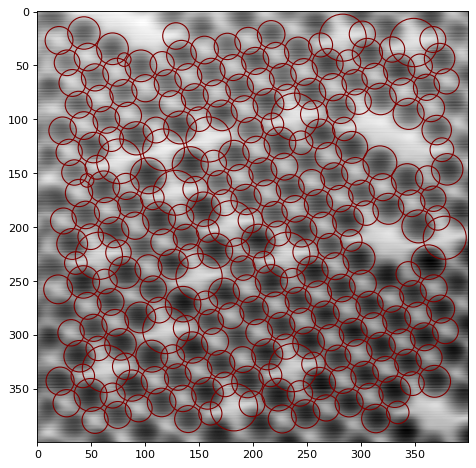

Distribution of the keypoints radius (post-filtering):


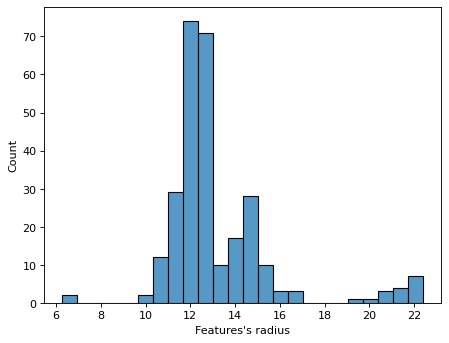

Median filtered kps' radius: 12.48 pixels.


In [18]:
print('After filtering:')
utilities.plot_clusters(np.array(gray_original), kp, labels=np.zeros(np.size(kp)), fill=False,
                        colormap="jet")
plt.show()

print('Distribution of the keypoints radius (post-filtering):')
plt.figure(dpi=80)
sns.histplot(sizes)
plt.xlabel('Features\'s radius')
plt.show()
print('Median filtered kps\' radius:', size_med.round(2), 'pixels.')

##### BREAKING ROTATIONAL INVARIANCE

In [19]:
for i in range(np.size(kp)):
    kp[i].angle = 0

kp, des = sift.compute(gray,kp)

### Clustering
Cluster the features, extract the reference cluster. From this cluster the median feature will be extracted.

In [20]:
kp, des = sift.compute(gray,kp)

In [21]:
labels = utilities.find_best_clustering(des, span=clustering_span_kp,
                              sklearn_clustering=AgglomerativeClustering)


Maximal silhouette score found with 11 clusters:
sil_score = 0.27804887294769287


Clusters visualization:


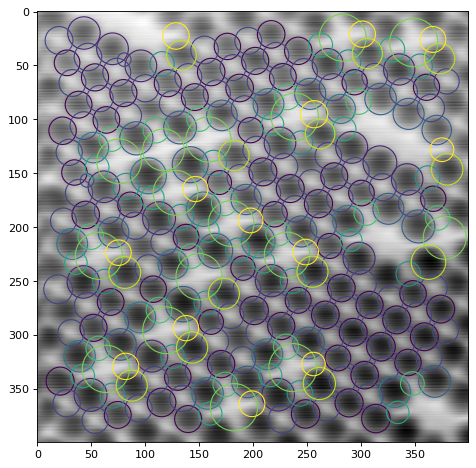

In [22]:
print('Clusters visualization:')
utilities.plot_clusters(np.array(gray_original), kp, labels, fill=False, colormap="viridis")
plt.show()

Sorted clusters' population: [79, 60, 19, 17, 16, 16, 16, 14, 14, 13, 13]
Pop. of the chosen cluster: 60
Chosen reference cluster:


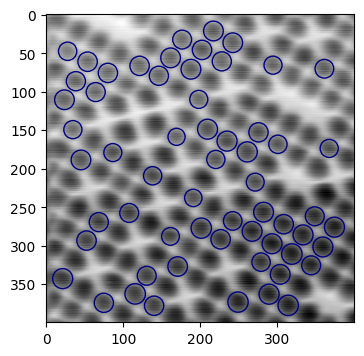

In [23]:
#setting the reference cluster:
bins = np.bincount(labels)
bins = list(bins)
bins_old = bins
ref_cluster = cluster_choice -1
bins = sorted(bins, reverse=True)
print('Sorted clusters\' population:', bins)

lab_max = bins[ref_cluster]
print('Pop. of the chosen cluster:', lab_max)
for i in range(len(bins)):
    if bins_old[i] == lab_max:
        l_max = i
        break

fig=plt.figure(figsize=(4, 4), facecolor='w', edgecolor='k')
utilities.plot_one_cluster(np.array(gray_original), kp, labels, l_max, fill=False)
print('Chosen reference cluster:')
plt.show()

In [24]:
### Keep only the kp belonging to the ref. cluster

x = np.array([kp[i].pt for i in range(np.size(kp))]) #kp coordinates
x = np.unique(x[labels==l_max,:], axis=0) # x of ref. cluster

kp_tmp = list(kp)
kp = []
kp_ind = [i for i in range(np.size(kp_tmp)) if kp_tmp[i].pt in x]
for i in kp_ind:
    kp.append(kp_tmp[i])

sizes = [kp[i].size for i in range(np.size(kp))]
size_med = np.median(sizes)
print('Median filtered kps\' radius:', size_med.round(2), 'pixels.')

Median filtered kps' radius: 12.53 pixels.


### Peak finder
Finally extract the median feature, and draw a correlation map with the full image. The peaks will be extracted from the correlation map, not the image itself!

In [25]:
img_original = img_original/255

Shape of the coordinate vector: (60, 2)
Shape of the crop vector: (60, 24, 24)


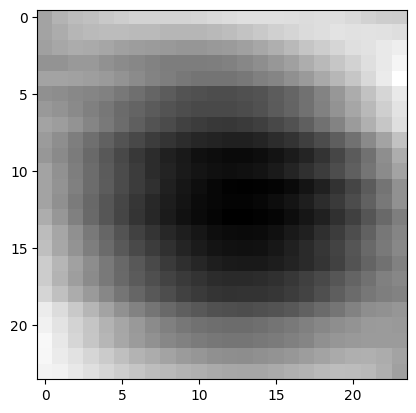

In [26]:
print('Shape of the coordinate vector:', x.shape)
crops = []
r = int(size_med*r_rescale)

# more control in the crop, add some constraint in the indices
for i in range(len(x)):
    crop = img_original[int(x[i, 1]-r) : int(x[i, 1]+r), #x, y SOMEHOW SWAPPED!!!!!
                        int(x[i, 0]-r) : int(x[i, 0]+r)]
    if len(crop[0,:]==crop[:,0]): # avoid size mismatch
        crops.append(crop)

print('Shape of the crop vector:', np.shape(crops))
median_crop = np.median(crops, axis=0)
plt.imshow(median_crop, cmap='gray') #, vmin=0, vmax=1)
# plt.imsave(path+'last_crop.png', median_crop, cmap="gray") #, vmin=0, vmax=1)

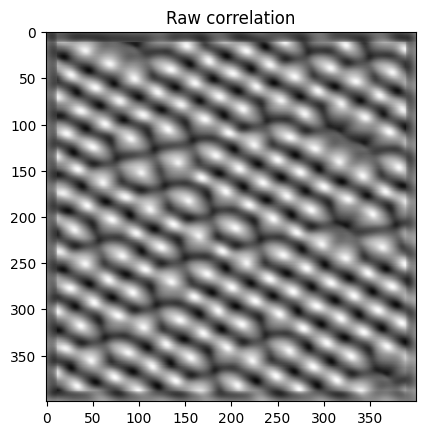

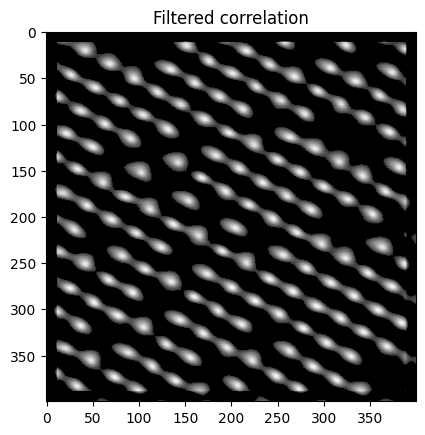

In [27]:
correlation = match_template(gray, median_crop, pad_input=True)
plt.imshow(correlation, cmap='gray', vmin=-1, vmax=1)
plt.title('Raw correlation')
plt.show()
correlation[correlation<0.2] = 0  ### I'm detecting maxima, so no np.abs needed.
                                    # also speeds up the following calculations
plt.title('Filtered correlation')
plt.imshow(correlation, cmap='gray', vmin=0, vmax=1)
plt.show()

Unfiltered detected peaks: 156


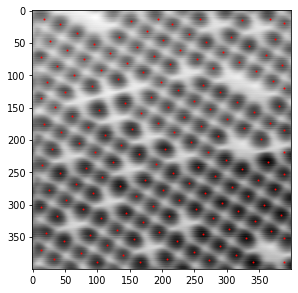

In [28]:
# Filtering the correlation in the previous cell speeds up this calculation:
locations = peak_local_max(correlation, min_distance=int(r*d_rescale))
print('Unfiltered detected peaks:', len(locations))
plt.figure(dpi=70)
plt.scatter(locations[:,1], locations[:,0], color='red', s=1)
plt.imshow(gray, cmap='gray')
plt.show()

Atom count after background filtering: 153


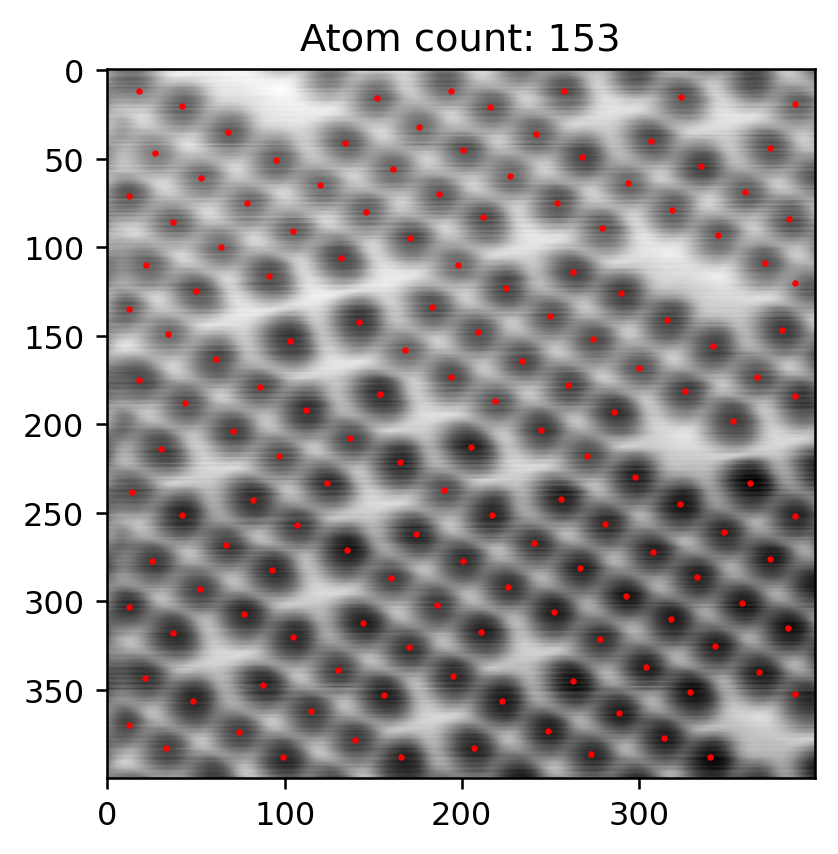

In [29]:
locations = locations[correlation[locations[:,0], locations[:,1]]>min_correl]

#Get rid from spurious points detected in the background of a segmented image...
# COMMENT the line(s) if the relevant signal is pitch black and/or very bright
# ...if the background is black:
locations = locations[gray[locations[:,0], locations[:,1]]>0]
# ...if the background is white:
locations = locations[gray[locations[:,0], locations[:,1]]<0.8*255]

count = len(locations)
print('Atom count after background filtering:', count)
plt.figure(figsize=(4, 4), dpi=230)
plt.title("Atom count: "+str(count)) #+" (NOT FITTED!)")
plt.scatter(locations[:,1], locations[:,0], color='red', s=1)
plt.imshow(img_original, cmap='gray')
plt.savefig(path+"last_count.png")


## Lattice vectors, deviations
For now, this procedure is not accurate enough to capture small deviations. The reason is that the features' positions are not found with sub-pixel accuracy. Work in progress...

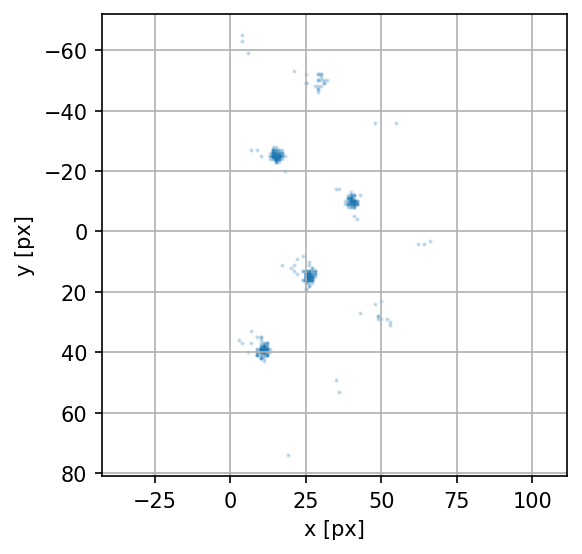

Clustering NNV's of maximally represented feature class:
Maximal silhouette score found with 11 clusters:
sil_score = 0.9019461504067106
Primitive vectors coordinates:
a = ( 14.96 +/- 1.46,-25.13 +/- 1.15)
           b = ( 25.60 +/- 1.56, 14.54 +/- 1.70)


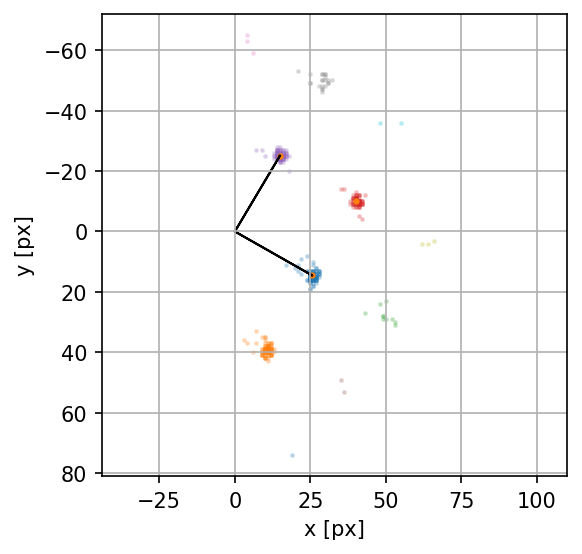

||a|| = 29.24 pixels.
||b|| = 29.44 pixels.


In [31]:
locations_swap = np.copy(locations) # Here x and y are swapped...
dum0 = locations[:,0]
dum1 = locations[:,1]
locations_swap[:,1] = dum0
locations_swap[:,0] = dum1

a, b = utilities.find_lattice_vectors(locations_swap, path, cluster_kNN_low, cluster_kNN_high,
                        clustersize_Threshold)

mod_a = np.sqrt(a[0]**2 + a[1]**2)
mod_b = np.sqrt(b[0]**2 + b[1]**2)

print('||a|| = '+str(round(mod_a, 2))+ ' pixels.')
print('||b|| = '+str(round(mod_b, 2))+ ' pixels.')

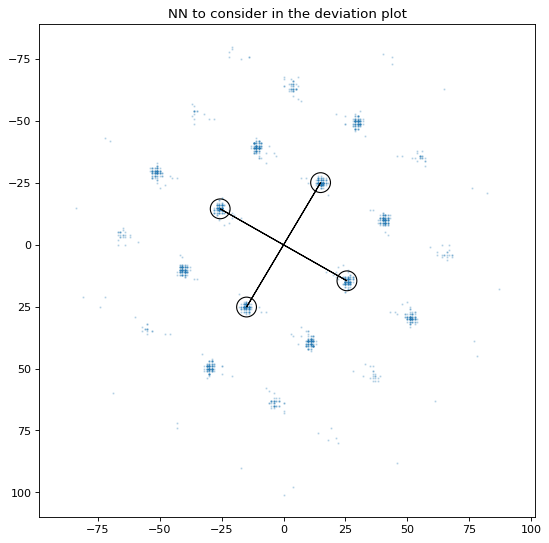

Sublattice 0.0:


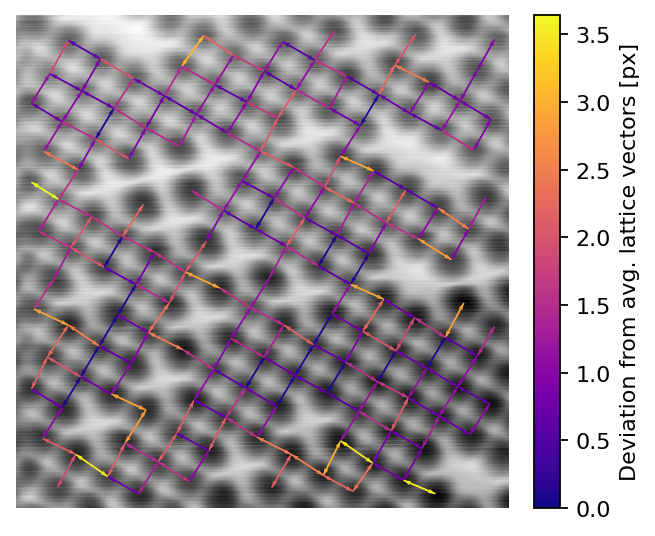

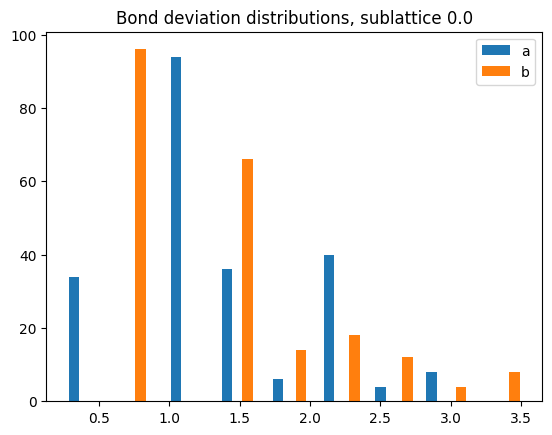

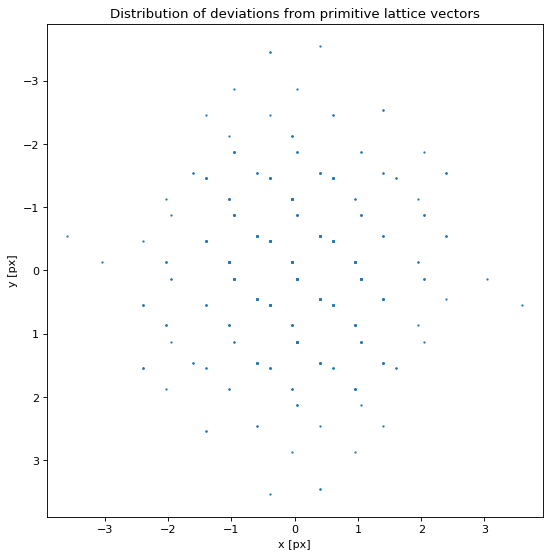

In [32]:
dum_labels = np.zeros(len(locations_swap)) # Function made for a different main purpose, so I'm inserting a dummy variable.
utilities.plot_lattice_deviations(locations_swap, a, b, dum_labels, k2, rtol_rel, path,
                                arrow_width, img_original, colorsmin=0, colorsmax=c_max_arrow)

### #################################